# Summary of the observations

- Florian and Rainer stood a couple of meters apart both observing the ISS transit
- Rainer used a 100m APO on an AltAz mount along with as EOS700D camera
- Florian used the C8 Cassegrain telescope along with an EOS750D camera

The following parameters are important for the analysis later as calculated for the midpoint between both observation sites:


Fri 2023-08-18, 12:03:52.73  •  Sun transit
ISS angular size: 49.70″; distance: 555.98 km
Angular separation: 4.0′; azimuth: 154.5°; altitude: 48.4°
Center line distance: 0.80 km; visibility path width: 6.23 km
Transit duration: 0.74 s; transit chord length: 30.6′

R.A.: 09h 50m; Dec: +13° 10′; parallactic angle: 15.4°
ISS velocity: 41.6 ′/s (angular); 6.73 km/s (transverse)
ISS velocity: 3.06 km/s (radial); 7.39 km/s (total);
Direction of motion relative to zenith: 124.8°
Sun angular size: 31.6′; 38.2 times larger than the ISS

## Video facts:
Rainer' Video:
The ISS passage starts at roughly 02:08

Florian's Video:
The ISS passage starts at roughly 01:09

In [1]:
## Convert the video files into single, stckable images
import cv2
import os

def extract_frames(video_path, output_folder):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file")
        return
    
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    frame_count = 0
    
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        
        # Break the loop if we have reached the end of the video
        if not ret:
            break
        
        # Save the frame as an image
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_count += 1
    
    # Release the video capture object
    cap.release()
    
    print(f"{frame_count} frames extracted and saved in {output_folder}")


video_path = "rainer_crop.mp4"  # Replace with your input video file
output_folder = "rainer_frames"  # Replace with the desired output folder name

extract_frames(video_path, output_folder)

76 frames extracted and saved in rainer_frames


# Align all the images (using the pillow package)

In [16]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

in_image  = "rainer_frames/"
reference = "rainer_frames/frame_0029.jpg"

counter = 0
for image in tqdm(glob(in_image + "*.jpg")):
    # Open the image files.
    img1_color = cv2.imread(image) # Image to be aligned.
    img2_color = cv2.imread(reference) # Reference image.
    
    # Convert to grayscale.
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape
    
    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)
    
    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    # (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)
    
    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    
    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)
    
    # Sort matches on the basis of their Hamming distance.
    matches = list(matches)
    matches.sort(key = lambda x: x.distance)
    
    # Take the top 90 % matches forward.
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)
    
    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    
    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt
    
    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    
    # Use this matrix to transform the
    # colored image wrt the reference image.
    transformed_img = cv2.warpPerspective(img1_color,
    					homography, (width, height))
    
    # Save the output.
    cv2.imwrite(in_image + "%i_align.jpg" % counter, transformed_img)
    counter += 1
    #cv2.imwrite(in_image[:-4] + "_align.jpg", transformed_img)


100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  6.83it/s]


## Use numpy image stabilization routines

(3, 19, 1080, 1920)


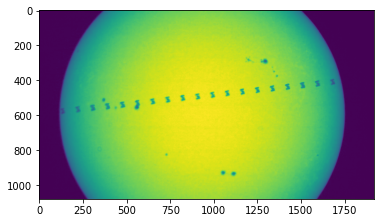

100%|██████████| 18/18 [01:55<00:00,  6.40s/it]


In [17]:
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_offset(ref_image, comp_image, box_size=10):
    
    ref_shape = ref_image.shape
    
    if len(ref_image.shape) > 2:
        raise Exception("[ERROR] Dimension of image too high. Please only use two-dimensional image arrays.")
    
    x, y = np.meshgrid(np.arange(-box_size, box_size), np.arange(-box_size, box_size))
    x = np.ravel(x)
    y = np.ravel(y)
    
    correlation = []
    
    aligned_image = np.zeros(ref_shape)
    maxcorr = 0.
    for dx, dy in zip(x, y):
        corr_array = np.zeros((2 * box_size + ref_shape[0], 2 * box_size + ref_shape[1]))
        corr_array[box_size:box_size+ref_shape[0], box_size:box_size+ref_shape[1]] = ref_image
        corr_array[box_size + dx:box_size + dx + ref_shape[0], box_size + dy:box_size + dy + ref_shape[1]] *= comp_image
        
        if maxcorr < np.sum(corr_array):
            aligned_image = np.zeros((2 * box_size + ref_shape[0], 2 * box_size + ref_shape[1]))
            aligned_image[box_size + dx:box_size + dx + ref_shape[0], box_size + dy:box_size + dy + ref_shape[1]] = comp_image
            aligned_image = aligned_image[box_size:-box_size, box_size:-box_size]
    
    return aligned_image


all_images = glob("florian_frames/*.jpg")
#all_images = glob("rainer_frames/*.jpg")
all_data = [np.array(cv2.imread(image)) for image in all_images]
all_data = np.transpose(all_data, axes=[3,0,1,2])
print(all_data.shape)
plt.imshow(np.min(all_data[0, :, :, :], axis=0))
plt.show()

all_data_aligned = [all_data[1, 0]]

for i in tqdm(range(all_data.shape[1])[1:]):
    all_data_aligned.append(find_offset(all_data[0, 0], all_data[0, -1]))

all_data_aligned = np.array(all_data_aligned)

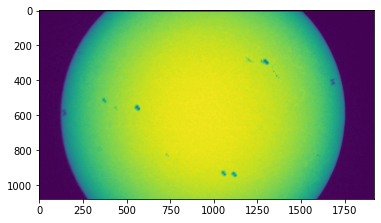

In [18]:
plt.imshow(np.min(all_data_aligned, axis=0))
plt.show()